# Point Pattern Analysis

This notebook contains a few utility functions for analyzing point patterns.

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import shapely
from IPython.core.pylabtools import figsize
figsize(8,8)

In [2]:
gdf = gpd.read_file("../../data/yellow_taxi_pickups_in_service_zone.geojson")

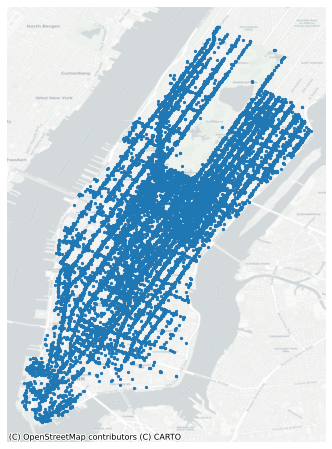

In [3]:
ax = gdf.plot(markersize=5)
cx.add_basemap(ax, crs=gdf.crs,
               source = cx.providers.CartoDB.Positron)
ax.axis('off');

# Making a Square Grid

In [4]:
def make_grid(gdf, n_cells):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax= gdf.total_bounds
    cell_size = (xmax-xmin)/n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)
    return grid

In [5]:
grid = make_grid(gdf, n_cells=20)

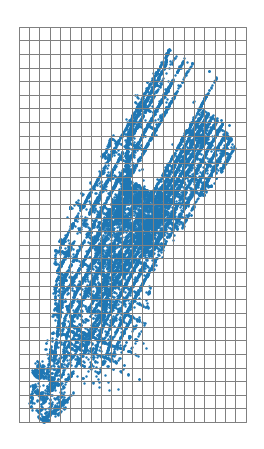

In [6]:
ax = gdf.plot(markersize=2)
grid.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

# Making a Hexagon Grid

In [7]:
from tobler.util import h3fy

# H3 needs a polygon as input, so use bounding box
bounding_box = gdf.dissolve().envelope[0]
bounding_box = gpd.GeoDataFrame(geometry=[bounding_box])
bounding_box.crs = gdf.crs

hex_grid = h3fy(bounding_box, resolution=9)

//anaconda3/envs/info615/lib/python3.9/site-packages/tobler/util/util.py:151: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  source = source.explode()


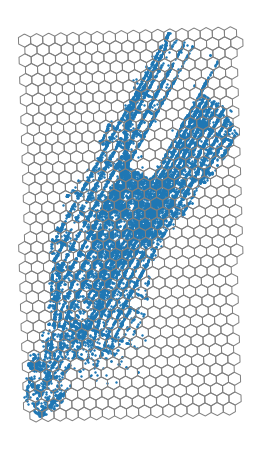

In [8]:
ax = gdf.plot(markersize=2)
hex_grid.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

# `Rasterize` Function

Aggregates a set of points over some grid and calculates summary stats.

In [9]:
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged = gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column
        merged[column] = 1
    else:
        output_col = column + "_" + aggfunc   
    dissolved = merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns = [output_col]
    grid.loc[dissolved.index, output_col] = dissolved[output_col].values
    if plot:
        ax = grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True)
        ax.axis('off')
        cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf.crs)
        plt.show()
    return grid

Counting points across the square grid we created.

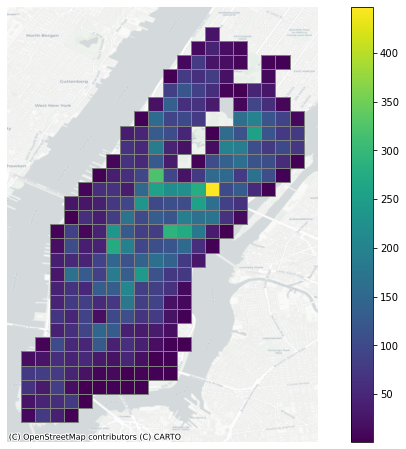

In [10]:
r = rasterize(gdf, grid, aggfunc="count")

Calculating average total invoice amount per grid cell (again, using the square grid that we created).

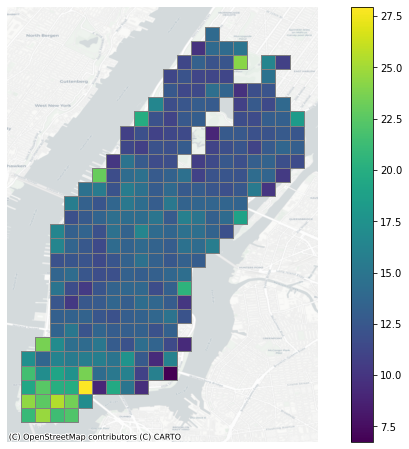

In [11]:
r = rasterize(gdf, grid, aggfunc="mean", column='total_amount')

Counting points per grid cell (now using our hexagon grid).

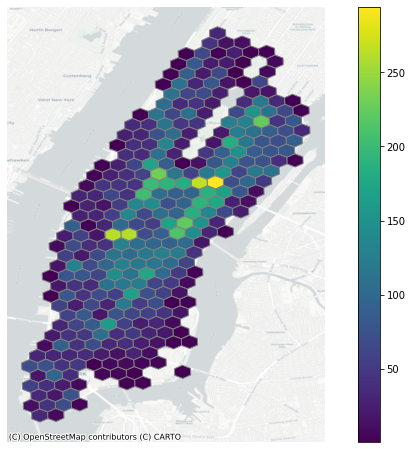

In [12]:
r = rasterize(gdf, hex_grid, aggfunc="count")

Calculating average total invoice amount per grid cell (now using the hexagon grid).

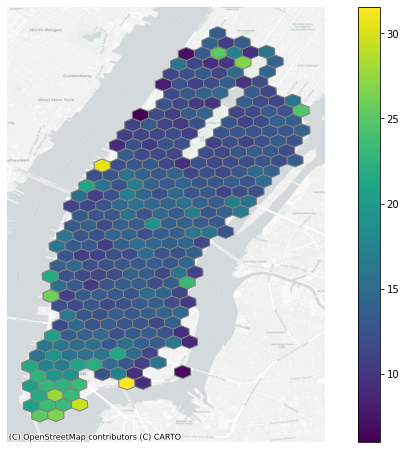

In [13]:
r = rasterize(gdf, hex_grid, aggfunc="mean", column='total_amount')

# Demonstration of Ripley's G Test

First, project the point pattern into an appropriate CRS.

In [14]:
gdf = gdf.to_crs(6933)

Next, create a two-dimensional array with just the point coordinates (these are now in meters).

In [15]:
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y
coords = gdf[['x', 'y']].to_numpy()

In [16]:
coords

array([[-7136491.7422487 ,  4781501.74980814],
       [-7135706.53690002,  4783242.63589668],
       [-7139127.45796631,  4778461.47666433],
       ...,
       [-7137271.25490685,  4781016.88965804],
       [-7140941.59300759,  4777604.45973088],
       [-7138290.92191654,  4782154.68483641]])

Now we are ready to run the test.

In [17]:
from pointpats import distance_statistics

Run the G test keeping 99 simulations across 40 different distances.

In [18]:
g_test = distance_statistics.g_test(
    coords, support=40, keep_simulations=True,
    n_simulations=99)

Here is a utility function to plot the results of the above G test (this will work with any other of the distance tests in PySAL):

In [19]:
def plot_test_results(test_results, input_coords, alpha=1):
    input_coords = input_coords.copy()
    f,ax = plt.subplots(1,2,figsize=(12,6), 
                    gridspec_kw=dict(width_ratios=(6,3)))
    
    # plot all the simulations with very fine lines
    ax[0].plot(test_results.support, test_results.simulations.T, color='k', alpha=.1, linewidth=4)
    # and show the average of simulations
    ax[0].plot(test_results.support, np.median(test_results.simulations, axis=0), color='cyan', linewidth=4, label='median simulation')

    # and the observed pattern's G function
    ax[0].plot(test_results.support, test_results.statistic, label = 'observed', color='red',linewidth=4)
    
    # clean up labels and axes
    ax[0].set_xlabel('distance')
    ax[0].legend()
    ax[0].set_xlim(0,200)
    test_name = str(type(test_results)).replace("pointpats.distance_statistics.","").split("'")[1].replace("testResult","")    
    ax[0].set_title(f"{test_name}")
    
    # plot the pattern itself on the next frame
    ax[1].scatter(*input_coords.T, alpha)
    # and clean up labels and axes there, too
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_title('Observed Point Pattern')
    f.tight_layout()
    plt.show()

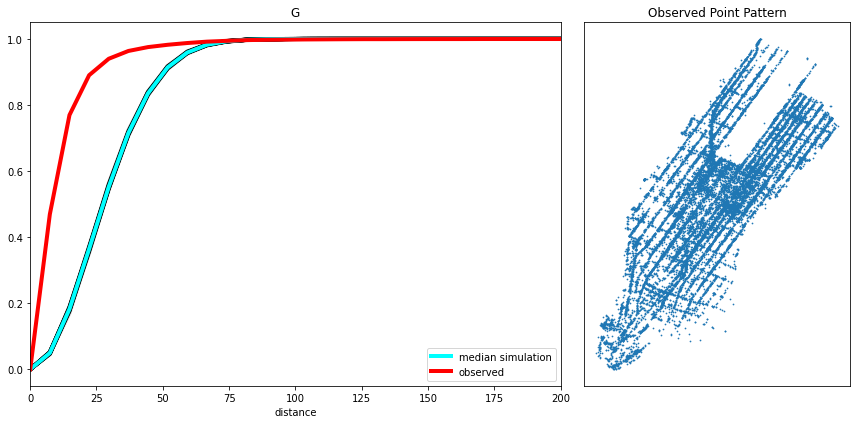

In [21]:
plot_test_results(g_test, coords, alpha=0.5)